### Imports

In [295]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib
%matplotlib inline
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, spearmanr
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


### Constants

In [228]:
DATA_FOLDER = 'data'
FOOD_FILE = 'food_data.csv'
COUNTRIES_FILE = 'countries_info.csv'
OVERWEIGHT_FILE = 'overweight.csv'
DIABETES_FILE = 'diabetes.csv'
POPULATION_FILE = 'population.csv'
IHD_FILE = 'ihd.csv'
JSON_COUNTRIES_FILE = 'world-countries.json'
COUNTRIES_CONTINENTS = 'countries_continents.csv'

### Read Data

In [229]:
all_datas = pd.read_csv(DATA_FOLDER + "/" + FOOD_FILE, sep='\t', low_memory=False)
countries_infos = pd.read_csv(DATA_FOLDER + "/" + COUNTRIES_FILE, sep=',', low_memory=False)
overweight = pd.read_csv(DATA_FOLDER + "/" + OVERWEIGHT_FILE, sep=',', low_memory=False)
diabetes = pd.read_csv(DATA_FOLDER + '/' + DIABETES_FILE, low_memory=False)
ihd = pd.read_csv(DATA_FOLDER + '/' + IHD_FILE, low_memory=False)
population = pd.read_csv(DATA_FOLDER + '/' + POPULATION_FILE, low_memory=False)
countries_shapes = pd.read_json(DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, orient='columns')
countries_continents = pd.read_csv(DATA_FOLDER + '/' + COUNTRIES_CONTINENTS, low_memory=False, index_col='Code')

### Analyse the different datasets

### Open Food Facts 

In [230]:
food_data = all_datas.copy()
food_data.shape

(685395, 173)

We can see that open food facts has 173 features. This is a lot of information!
We have to select only the features which could help us to answer our questions. 
We would like to see the number of entries per features, to see which would have enough samples for our data, once all NaN values of a row are dropped.

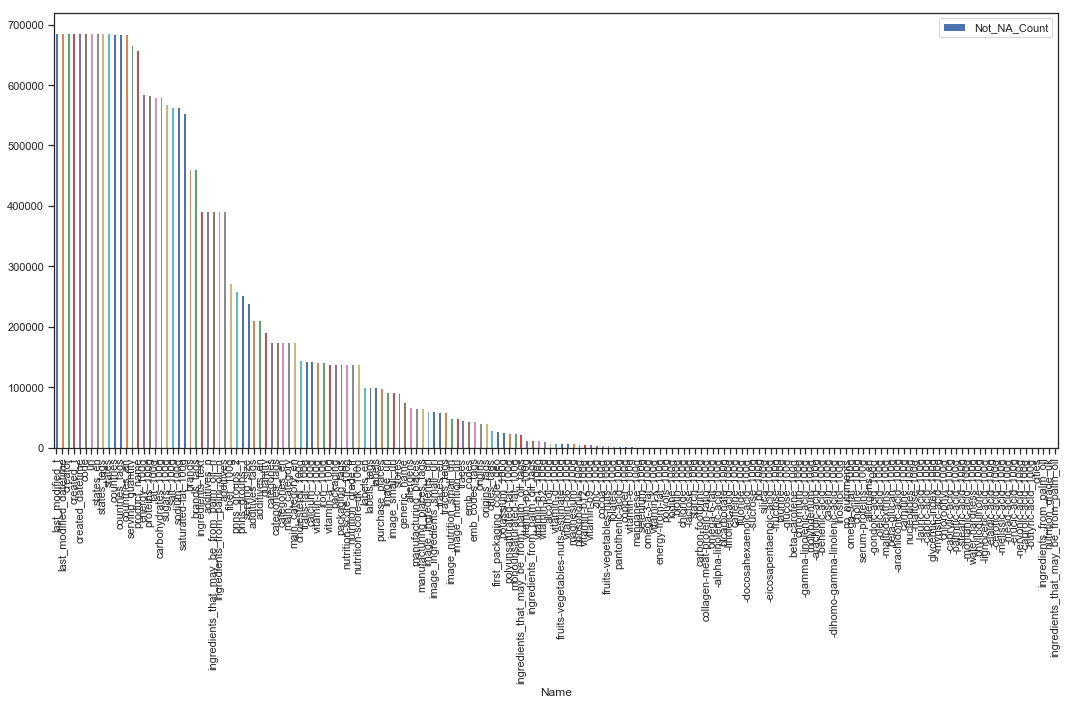

In [231]:
not_na = []
#for each feature in our dataset
for c in food_data.columns.values: 
    #count na values per feature
    count = food_data[c].notna().sum()
    not_na.append((c, count))
#create df with feature name and number of valid entries
df = pd.DataFrame(not_na, columns=['Name','Not_NA_Count'])
#sort
df.sort_values(by='Not_NA_Count', inplace=True, ascending=False)
df = df.reset_index(drop=True)
#plot
df.plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,8))

We can see that although there are many available features, over half of them have a very small amount of entries. 

Let's plot a graph with a threshold on the amount of entries, i.e. 10000

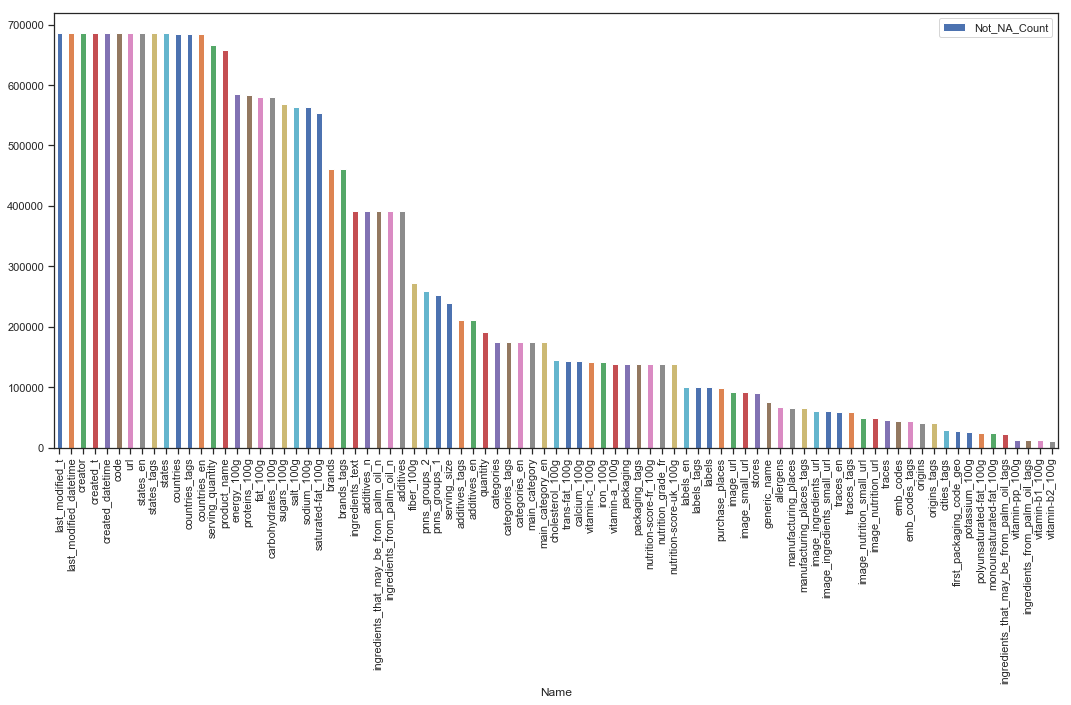

In [232]:
threshold = 10000
df[df['Not_NA_Count'] > threshold].plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,8))

This is already better, but we can see that there are a lot of features that are not useful to us (i.e. last_modified_t, creator, url, states, ...). 

We have thus selected features that we judge will be interesting to look at later on in our study

In [233]:
features = ['product_name', 'countries','countries_tags','sugars_100g','fat_100g',
            'energy_100g','carbohydrates_100g','proteins_100g','salt_100g','sodium_100g',
            'saturated-fat_100g','ingredients_text', 'fiber_100g','serving_size', 'additives_en']

In [234]:
food_data[features].dropna().shape

(98828, 15)

If we drop all rows with NaN values, we still have a sample of 98828 entries, which we judge to be sufficient.

Features that will be useful to our study:
 - product_name: name of product
 - countries/countries_tags:  list of countries where the product is sold
 - sugars_100g, fat_100g, energy_100g, carbohydrates_100g, proteins_100g, salt_100g, sodium_100g , saturated-fat_100g, fiber_100g: the amount of a nutriment (in g, or kJ for energy) for 100 g
 - ingredients_text: ingredients contained in the product
 - additives_en: additives found in the product


We have spotted that there will be some work to do in order to group products by countries, since some products are sold in many countries. The countries_tags consist of a list of countries, with a language tag followed by the country name (in said language).
For example:

In [235]:
food_data['countries_tags'].value_counts()[150:160]

en:belgium,en:netherlands                    25
en:france,en:spain,en:switzerland            24
en:belgium,en:switzerland                    24
en:france,en:switzerland,en:united-states    24
en:france,en:united-arab-emirates            24
en:poland,en:united-kingdom                  23
en:france,en:germany,en:en                   23
en:latvia                                    23
en:france,en:mexico                          22
en:france,en:india                           22
Name: countries_tags, dtype: int64

This is why we have a dataset associating country names (in different languages) with their alpha codes.

### Countries

As stated above, this dataset associates a country name in a certain language, with the language tag, the alpha 2/3 code and the numeric code. 
We will use it to group the countries of the food data together.

In [236]:
countries_infos.shape

(20169, 6)

In [237]:
countries_infos.head()

,LANG,LANG_NAME,COUNTRY_ALPHA2_CODE,COUNTRY_ALPHA3_CODE,COUNTRY_NUMERIC_CODE,COUNTRY_NAME
0,AF,AFRIKAANS,AD,AND,20,Andorra
1,AF,AFRIKAANS,AE,ARE,784,Verenigde Arabiese Emirate
2,AF,AFRIKAANS,AF,AFG,4,Afganistan
3,AF,AFRIKAANS,AG,ATG,28,Antigua en Barbuda
4,AF,AFRIKAANS,AI,AIA,660,Anguilla


### Countries/Continents
Association of countries (alpha 2 code) with their continent code
[https://dev.maxmind.com/geoip/legacy/codes/country_continent/]

In [238]:
countries_continents.head()

,Continent
Code,
AD,EU
AE,AS
AF,AS
AG,NaN
AI,NaN


### Countries Shapes
Json file associating a country with its border coordinates. 
This will be used to display maps.
Example:
```json
{
    "type":"Feature",
    "properties":{"name":"Afghanistan"},
    "geometry":{"type":"Polygon","coordinates":[[[61.210817,35.650072],...,[61.210817,35.650072]]]},
    "id":"AFG"
}
```

### Overweight
This data indicates the population percentage which is overweight, for a certain country and by year.

We choose to work only with the last year of the database (2016).

In [239]:
overweight.shape

(8022, 4)

In [240]:
overweight.head()

,Entity,Code,Year,Indicator
0,Afghanistan,AFG,1975,0.5
1,Afghanistan,AFG,1976,0.5
2,Afghanistan,AFG,1977,0.6
3,Afghanistan,AFG,1978,0.6
4,Afghanistan,AFG,1979,0.6


###  Diabetes
Prevalence of diabetes per category and per country for the year 2017.
We will only look at the country/territory and Diabetes [18-99] national prevalence[%]

In [241]:
diabetes.shape

(221, 23)

In [242]:
diabetes.head()

,country_id,country/territory,idf_reg,"Adults with diabetes[18-99] in 1,000s",prev,Unnamed: 5,"Adults with diabetes confidence interval in 1,000s Min","Adults with diabetes confidence interval in 1,000s Max",Diabetes [18-99] national prevalence[%],Diabetes National prevalence confidence interval Min,...,Diabetes age-adjusted comparative prevalence confidence interval Max,"Undiagnosed diabetes [18-99] in 1,000",Undiagnosed diabetes confidence interval Min,Undiagnosed diabetes confidence interval Max,Mean Expenditure per person with diabetes (18-99) USD,Mean Expenditure per person with diabetes (18-99) ID,Diabetes related deaths (20-99),Diabetes related deaths confidence interval Min,Diabetes related deaths confidence interval Max,Data source of Diabetes prevalence estimates: extrapolation which countries
0,1,Afghanistan,MENA,1054.460430,0.061482,NaN,840.613890,1494.825185,6.15%,4.90%,...,13.80%,733.870351,585.040076,1040.349976,115.0,338.0,20960.044220,16688.839490,28361.868260,Islamic Republic of Iran
1,2,Albania,EUR,267.266724,0.119302,NaN,232.694171,304.292989,11.93%,10.39%,...,11.29%,108.610335,94.560937,123.656858,369.0,832.0,2845.686077,2536.877271,3189.789573,"Croatia, Cyprus,Greece, Slovenia,Turkey"
2,3,Algeria,MENA,1884.558775,0.068824,NaN,1247.936183,2629.709395,6.88%,4.56%,...,9.34%,1239.097394,820.518040,1729.033927,567.0,1461.0,15935.260820,8224.120172,21417.754870,NaN
3,4,Andorra,EUR,7.219999,0.127023,NaN,6.118940,9.315789,12.70%,10.77%,...,10.71%,2.581379,2.187715,3.330690,4431.0,5053.0,32.195171,27.947857,39.597543,"Portugal, Spain"
4,5,Angola,AFR,359.075986,0.029196,NaN,217.039437,576.950839,2.92%,1.76%,...,5.86%,178.444879,107.858998,286.719042,381.0,507.0,6256.612054,3802.686528,9739.760748,"Botswana, Mozambique, South Africa, Zimbabwe"


### Ischaemic  Heart   Disease
Number of deaths (in thousands) of IHD per country, for the year 2008. 
It was really hard to find official medical data, so even it is a decade ago, we are still interested in the trend. 

In [243]:
ihd.shape

(174, 2)

In [244]:
ihd.head()

,Country,IHD
0,USA,445.8
1,Germany,155.8
2,Japan,105.5
3,United Kingdom,92.3
4,Italy,87.8


### Population
Country population for the year 2008. 

In [245]:
population.shape

(236, 2)

In [246]:
population.head()

,Country,Population
0,China,1321851888
1,India,1129866154
2,European Union,490426060
3,United States,301139947
4,Indonesia,234693997


### Data Cleaning

We do some operations on the countries tags to be able to parse the data. 

We also remove potential outliers.
In our case, some outliers may be having a larger sugar or fat content than 100g, since it defies the laws of physics!

In [247]:
#select only relevant features for the countries infos
countries_infos = countries_infos[['COUNTRY_ALPHA2_CODE', 'COUNTRY_NAME', 'COUNTRY_ALPHA3_CODE']]
#merge with the countries continents in order to have the continents tag too
countries_infos = countries_infos.merge(countries_continents, left_on='COUNTRY_ALPHA2_CODE', right_index=True)
#fix bug - north america continent tag was set as NaN.
countries_infos['Continent'] = countries_infos['Continent'].replace(np.nan, 'NA', regex=True)

In [248]:
#select only relevant features
food_data = food_data[features]
#remove language tags from countries_tags and countries
food_data['countries_tags'] = food_data['countries_tags'].replace(regex=True, to_replace=r'\w\w:', value=r'')
food_data['countries'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
#make country names lower case
food_data['countries'] = food_data['countries'].apply(lambda x: str(x).lower())
#filter outliers
to_filter = ['sugars_100g','fat_100g','carbohydrates_100g','proteins_100g','salt_100g','sodium_100g',
            'saturated-fat_100g', 'fiber_100g']
for i in to_filter:
    food_data = food_data[food_data[i] <= 100]

In [249]:
#get a feeling of the data
food_data.head()

,product_name,countries,countries_tags,sugars_100g,fat_100g,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,fiber_100g,serving_size,additives_en
10,Solène céréales poulet,france,france,1.7,5.9,916.0,30.3,9.7,0.464,0.182677,0.5,"antioxydant : érythorbate de sodium, colorant ...",2.8,NaN,"E150 - Caramel,E160a - Alpha-carotene,E202 - P..."
11,Tarte noix de coco,france,france,21.9,22.0,1594.0,27.3,4.6,0.100,0.039370,15.5,NaN,4.4,NaN,NaN
17,Compote de poire,france,france,27.0,0.0,657.0,36.0,0.6,0.000,0.000000,0.0,NaN,3.6,NaN,NaN
22,Baguette Poitevin,france,france,0.6,6.7,866.0,27.5,8.9,0.400,0.157480,3.8,"baguette Poite vin Pain baguette 50,6%: fqrine...",1.7,NaN,NaN
31,Suedois saumon,france,france,4.6,4.4,720.0,23.3,8.4,3.580,1.409449,1.2,"Paln suédois 42,6%: farine de BLÉ, eau, farine...",2.7,NaN,"E300 - Ascorbic acid,E503 - Ammonium carbonates"


We contruct a datastructure with the countries codes map to their names (in different languages), in order to group all the different ways the countries were written together

In [250]:
countries = []

for c in food_data['countries_tags'].dropna():
    #split list of countries on the comma
    for country in c.split(','):
        country = country.lower()
        #check if any language tags are left over
        found = re.search('\w\w:(.+)', country, re.IGNORECASE)  
        if found:
            country = found.group(1)
        if country not in countries:
            countries.append(country)

countries_with_code = []
#apply lower case to country names
countries_infos['COUNTRY_NAME'] = countries_infos['COUNTRY_NAME'].apply(lambda x: str(x).lower())

for c in countries:
    is_present = False
    #loop over rows having matching country names with countries data
    for index, c_i in countries_infos[countries_infos['COUNTRY_NAME'] == c.lower()].iterrows():
        #add tuple containing country name,  country code and continent
        countries_with_code.append((c, c_i['COUNTRY_ALPHA2_CODE'], c_i['COUNTRY_ALPHA3_CODE'], c_i['Continent']))
        is_present = True
        break
    if not is_present:
        countries_with_code.append((c, "???", "???", "???"))

We select only the countries for which we have information. (They are contained in the open food database)

In [251]:
count = 0
proper_countries = []
for c in countries_with_code:
    if c[1] != "???":
        proper_countries.append(c)

In [252]:
#we saw that a few countries were not added, it must be something related to our above code or the dataset. 
#since there were only a few, we decided to add them by hand
to_append = [('united-states', 'US', 'USA','NA'), ('united-kingdom', 'GB', 'GBR', 'EU'), 
             ('french-polynesia', 'PF', 'PYF','OC'),
             ('hong-kong', 'HK', 'HKG','AS'), ('new-zealand', 'NZ','NZL', 'OC'), ('new-caledonia', 'NC', 'NCL', 'OC'),
             ('scotland','GB', 'GBR' ,'EU'), ('united-arab-emirates', 'AE', 'ARE', 'AS'), ('etats-unis', 'US', 'USA', 'NA'),
             ('czech-republic', 'CZ', 'CZE','EU'), ('south-africa', 'ZA', 'ZAF','AF'), ('quebec', 'CA', 'CAN','NA'), 
             ('south-korea', 'KR', 'KOR', 'AS'), ('united-states-of-america','US', 'USA', 'NA'), 
             ('russian-federation', 'RU', 'RUS', 'EU'), ('republic-of-korea','KR', 'KOR', 'AS'), 
             ('hong-kong-china', 'HK', 'HKG','AS'), 
             ('us', 'US', 'USA','NA'), ('usa', 'US', 'USA','NA')]
for i in to_append:
    proper_countries.append(i)

In [294]:
proper_countries[0:10]

[('france', 'FR', 'FRA', 'EU'),
 ('canada', 'CA', 'CAN', 'NA'),
 ('oman', 'OM', 'OMN', 'AS'),
 ('germany', 'DE', 'DEU', 'EU'),
 ('belgium', 'BE', 'BEL', 'EU'),
 ('netherlands', 'NL', 'NLD', 'EU'),
 ('switzerland', 'CH', 'CHE', 'EU'),
 ('mexico', 'MX', 'MEX', 'NA'),
 ('italy', 'IT', 'ITA', 'EU'),
 ('australia', 'AU', 'AUS', 'OC')]

In [30]:
def explode(df):
    rows = []
    #for each row
    for index, data in df.iterrows():
        #split the countries by the comma
        countries = str(data['countries_tags']).split(',')
        #for each country
        for country in countries:
            #replace data with country
            data['countries'] = country
            #add row to dataset
            rows.append(data)
    #create new dataframe with our exploded data
    return pd.DataFrame(rows)

In [31]:
exploded_data = explode(food_data)

Get country aplha 2 code, alpha 3 code and continent for each row

In [32]:
exploded_data.head()

,product_name,countries,countries_tags,sugars_100g,fat_100g,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,fiber_100g,serving_size,additives_en
10,Solène céréales poulet,france,france,1.7,5.9,916.0,30.3,9.7,0.464,0.182677,0.5,"antioxydant : érythorbate de sodium, colorant ...",2.8,NaN,"E150 - Caramel,E160a - Alpha-carotene,E202 - P..."
11,Tarte noix de coco,france,france,21.9,22.0,1594.0,27.3,4.6,0.100,0.039370,15.5,NaN,4.4,NaN,NaN
17,Compote de poire,france,france,27.0,0.0,657.0,36.0,0.6,0.000,0.000000,0.0,NaN,3.6,NaN,NaN
22,Baguette Poitevin,france,france,0.6,6.7,866.0,27.5,8.9,0.400,0.157480,3.8,"baguette Poite vin Pain baguette 50,6%: fqrine...",1.7,NaN,NaN
31,Suedois saumon,france,france,4.6,4.4,720.0,23.3,8.4,3.580,1.409449,1.2,"Paln suédois 42,6%: farine de BLÉ, eau, farine...",2.7,NaN,"E300 - Ascorbic acid,E503 - Ammonium carbonates"


In [33]:
#parsed_datas = exploded_data.merge(how='outer',country_codes_continent, left_on='countries_tags', right_on='country')
#parsed_datas['alpha2'].value_counts()

In [139]:
def get_tag(row, col1, col2, col3='alpha3', col4='continent'):
    #for each country
    for c in proper_countries:
        #if the country is found in proper countries
        if c[0] == row[col1]:
            #set the value of col2 to the country alpha 2 code
            row[col2] = c[1]
            #set the value of col3 to the country alpha 3 code
            row[col3] = c[2]
            #set the value of col4 to the continent
            row[col4] = c[3]
            return row
    #if nothing was found, we return TBD
    row[col2] = "TBD"
    row[col3] = "TBD"
    row[col4] = "TBD"
    return row

In [35]:
exploded_data['continent'] = ''
exploded_data['alpha3'] = ''
parsed_datas = exploded_data.apply(lambda x: get_tag(x, 'countries', 'countries_tags', 'alpha3', 'continent'), axis=1)


In [73]:
parsed_datas = parsed_datas.reset_index(drop=True)
parsed_datas.head()

,product_name,countries,countries_tags,sugars_100g,fat_100g,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,fiber_100g,serving_size,additives_en,continent,alpha3
0,Solène céréales poulet,france,FR,1.7,5.9,916.0,30.3,9.7,0.464,0.182677,0.5,"antioxydant : érythorbate de sodium, colorant ...",2.8,NaN,"E150 - Caramel,E160a - Alpha-carotene,E202 - P...",EU,FRA
1,Tarte noix de coco,france,FR,21.9,22.0,1594.0,27.3,4.6,0.100,0.039370,15.5,NaN,4.4,NaN,NaN,EU,FRA
2,Compote de poire,france,FR,27.0,0.0,657.0,36.0,0.6,0.000,0.000000,0.0,NaN,3.6,NaN,NaN,EU,FRA
3,Baguette Poitevin,france,FR,0.6,6.7,866.0,27.5,8.9,0.400,0.157480,3.8,"baguette Poite vin Pain baguette 50,6%: fqrine...",1.7,NaN,NaN,EU,FRA
4,Suedois saumon,france,FR,4.6,4.4,720.0,23.3,8.4,3.580,1.409449,1.2,"Paln suédois 42,6%: farine de BLÉ, eau, farine...",2.7,NaN,"E300 - Ascorbic acid,E503 - Ammonium carbonates",EU,FRA


In [61]:
#top 10 countries with entries
parsed_datas['countries_tags'].value_counts()[0:10]

US    136761
FR    101324
CH     12977
DE      4231
GB      4120
ES      3458
MX      1395
IT      1103
BE       958
NL       694
Name: countries_tags, dtype: int64

__Fun fact: Switzerland is the 3rd country with the most entries in the open food facts database!__

### Compute
Now we compute result from the parsed datasets. 
We would like to get the mean and median averages of nutriments_100g per country.
Since the entries per country vary in size and in types of foods, we thought it might be interesting to look at both averages.

In [62]:
grouped = parsed_datas.groupby(['countries_tags'])
mean = grouped.mean()
median = grouped.median()
counted = grouped.count()

### Sets
We define sets by continents to look at correlations later on. Note, antarctica had no entries so we discard it.

In [64]:
asia = parsed_datas[parsed_datas['continent'] == 'AS']
africa = parsed_datas[parsed_datas['continent'] == 'AF']
oceania = parsed_datas[parsed_datas['continent'] == 'OC']
europe = parsed_datas[parsed_datas['continent'] == 'EU']
north_america = parsed_datas[parsed_datas['continent'] == 'NA']
south_america = parsed_datas[parsed_datas['continent'] == 'SA']

In [65]:
def median_mean_grouped(df, group_by):
    grouped = df.groupby([group_by])
    median = grouped.median()
    mean = grouped.mean()
    return median, mean

In [66]:
asia_med, asia_mean = median_mean_grouped(asia, 'countries_tags')
africa_med, africa_mean = median_mean_grouped(africa, 'countries_tags')
oceania_med, oceania_mean = median_mean_grouped(oceania, 'countries_tags')
europe_med, europe_mean = median_mean_grouped(europe, 'countries_tags')
na_med, na_mean = median_mean_grouped(north_america, 'countries_tags')
sa_med, sa_mean = median_mean_grouped(south_america, 'countries_tags')

In [103]:
means = [mean, africa_mean, asia_mean, europe_mean, na_mean, sa_mean, oceania_mean]
medians = [median, africa_med, asia_med, europe_med, na_med, sa_med, oceania_med]
rows = [parsed_datas.shape[0], africa.shape[0], asia.shape[0], europe.shape[0], 
        north_america.shape[0], south_america.shape[0], oceania.shape[0]]
continent = ['ALL', 'AF', 'AS', 'EU', 'NA', 'SA', 'OC']
columns = ['Continent','Pearson', 'P-Value_Pearson','Spearman', 'P-Value_Spearman'
          #'Kendall', 
          ]

In [70]:
#re add continent to means/medians df
for i in range(1,len(means)):
    means[i]['continent'] = continent[i]
    medians[i]['continent'] = continent[i]

### Correlations and Plotting functions

We define various functions to get pretty plots for our data, as well as to get the correlations.

In [86]:
def plot_mean_med(df1, df2):
    f, ax = plt.subplots(nrows=2)
    a = df1.plot.bar(figsize=(15,5), ax=ax[0], title='Mean')
    b = df2.plot.bar(figsize=(15,5), ax=ax[1], title='Median')
    plt.tight_layout()
    plt.show()

In [150]:
def corr(df, x_, y_, continent, avg):
    pearson_coeff = pearsonr(df[x_], df[y_])
    spearman_coeff = spearmanr(df[x_], df[y_])
    return [continent,pearson_coeff[0], pearson_coeff[1], spearman_coeff[0], spearman_coeff[1]]

In [101]:
def plt_corr(df1, df2, continent, avg1, avg2, x_, y_, title_):
    f, ax = plt.subplots(ncols=2, sharey=True)
    a =  df1.plot(kind='scatter',x=x_,y=y_, title= continent + " : " + avg1 +" : "+ title_, figsize=(8,4),grid=True, ax=ax[0])
    b =  df2.plot(kind='scatter',x=x_,y=y_, title=continent + " : " + avg2 +" : "+ title_, figsize=(8,4),grid=True, ax=ax[1])
    plt.tight_layout()
    plt.show()
    corrs_avg1 = corr(df1, x_, y_, continent, avg1)
    corrs_avg2 = corr(df2, x_, y_, continent, avg2)
    return corrs_avg1, corrs_avg2

In [113]:
def plot(dfs_1, dfs_2, continents, avg1, avg2, x_, y_, title_, columns_):
    corrs_avg1 = []
    corrs_avg2 = []
    nb_rows = len(dfs_1)
    f, ax = plt.subplots(ncols=2, nrows=(nb_rows + 1), figsize=(10, 30))
    for i in range(nb_rows):
        a = dfs_1[i].plot(kind='scatter',x=x_,y=y_, title= continent[i] + " : " + avg1 +" : "+ title_, ax=ax[i][0])
        b = dfs_2[i].plot(kind='scatter',x=x_,y=y_, title= continent[i] + " : " + avg2 +" : "+ title_, ax=ax[i][1])
        c_1 = corr(dfs_1[i], x_, y_, continent[i], avg1)
        c_2 = corr(dfs_2[i], x_, y_, continent[i], avg2)
        corrs_avg1.append(c_1)
        corrs_avg2.append(c_2)
    corr1 = pd.DataFrame(corrs_avg1, columns = columns_)
    corr2 = pd.DataFrame(corrs_avg2, columns = columns_)
    c = corr1.plot.bar(x = 'Continent', ax=ax[nb_rows][0], title = 'Correlations : ' + avg1)
    d = corr2.plot.bar(x = 'Continent', ax=ax[nb_rows][1], title = 'Correlations : ' + avg2)
    plt.tight_layout()
    plt.show()
    #display(corr1.merge(corr2, left_on='Continent', right_on='Continent', suffixes=['_Mean', '_Median']))
    print('Mean')
    display(corr1)
    print('Median')
    display(corr2)
    #return corr1, corr2

In [54]:
def merge_all(dfs, merge_with, left_on_='countries_tags', right_on_='code', right_index=False):
    merged = []
    for i in dfs:
        if right_index:
            merged.append(i.merge(merge_with, left_on=left_on_, right_index=True))
        else:
            merged.append(i.merge(merge_with, left_on=left_on_, right_on=right_on_))
    return merged

In [164]:
def sns_plt(df1, df2, x_, y_, hue_, avg1, avg2, title_):
    fig, ax = plt.subplots(nrows=2)
    ax[0].set_title(avg1 + " : " + title_)
    ax[1].set_title(avg2 + " : " + title_)
    sns.set(style="ticks", rc={'figure.figsize':(10, 10)})
    sns.scatterplot(x=x_, y=y_, data=df1, hue=hue_, ax=ax[0])
    sns.scatterplot(x=x_, y=y_, data=df2, hue=hue_, ax=ax[1])
    plt.tight_layout()
    plt.show()

In [158]:
def show_corr(dfs1, dfs2, x_, y_, avg1, avg2, columns_, continent):
    corrs_avg1 = []
    corrs_avg2 = []
    nb_rows = len(dfs1)
    for i in range(nb_rows):
        c_1 = corr(dfs1[i], x_, y_, continent[i], avg1)
        c_2 = corr(dfs2[i], x_, y_, continent[i], avg2)
        corrs_avg1.append(c_1)
        corrs_avg2.append(c_2)
    f, ax = plt.subplots(ncols=2, figsize=(15, 8))
    corr1 = pd.DataFrame(corrs_avg1, columns = columns_)
    corr2 = pd.DataFrame(corrs_avg2, columns = columns_)
    c = corr1.plot.bar(x = 'Continent', ax=ax[0], title = 'Correlations : ' + avg1)
    d = corr2.plot.bar(x = 'Continent', ax=ax[1], title = 'Correlations : ' + avg2)
    plt.show()
    print('Mean')
    display(corr1)
    print('Median')
    display(corr2)

## Sugar vs. Fat

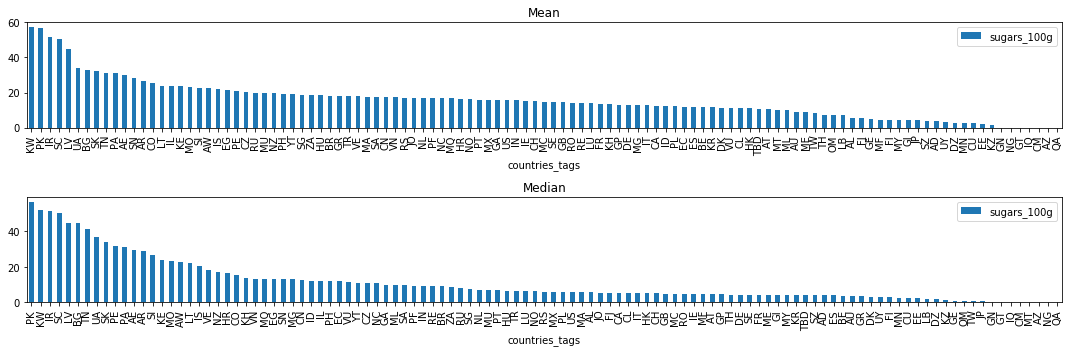

In [117]:
plot_mean_med(pd.DataFrame(mean['sugars_100g']).sort_values(by=['sugars_100g'], ascending=False), 
              pd.DataFrame(median['sugars_100g']).sort_values(by=['sugars_100g'], ascending=False))

Plots of mean and median quantity of sugar per 100g per country

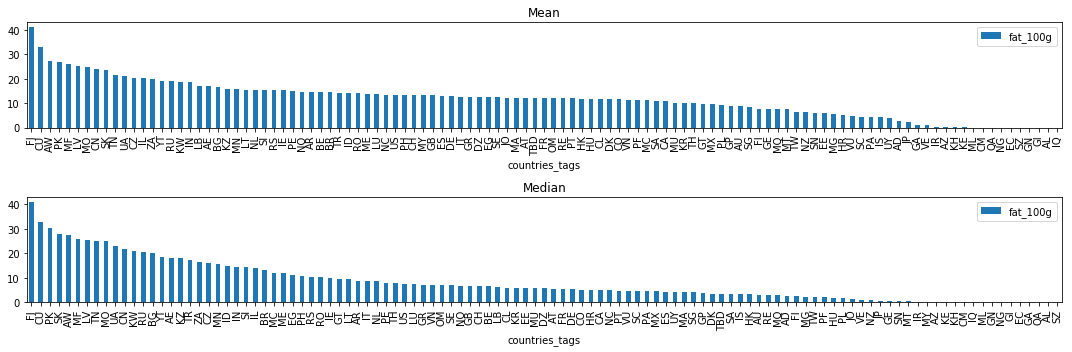

In [94]:
plot_mean_med(pd.DataFrame(mean['fat_100g']).sort_values(by=['fat_100g'], ascending=False), 
              pd.DataFrame(median['fat_100g']).sort_values(by=['fat_100g'], ascending=False))

Plots of mean and median quantity of fat per 100g per country

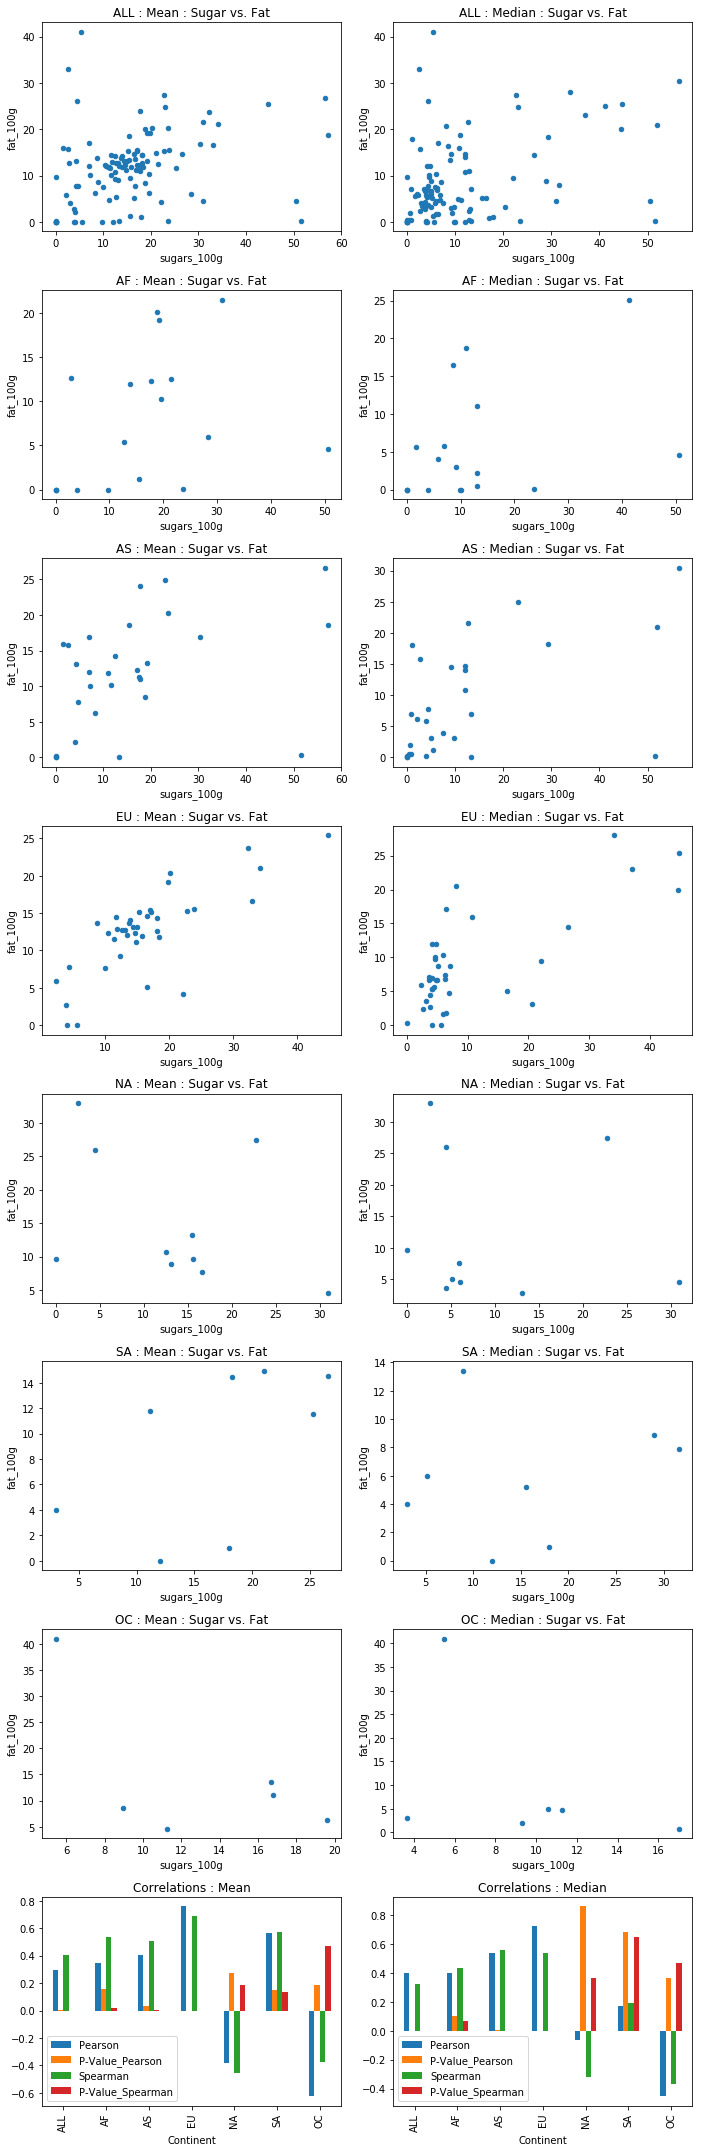

Mean


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.296206,1.596492e-03,0.402451,0.000012
1,AF,0.347315,1.579028e-01,0.536069,0.021836
2,AS,0.402714,3.031529e-02,0.505237,0.005181
3,EU,0.759464,2.079363e-08,0.688496,0.000001
4,NA,-0.385326,2.714946e-01,-0.454545,0.186905
5,SA,0.562230,1.469050e-01,0.571429,0.138960
6,OC,-0.625454,1.841558e-01,-0.371429,0.468478


Median


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.397509,1.560236e-05,0.323181,0.000541
1,AF,0.399091,1.008708e-01,0.438039,0.069037
2,AS,0.539406,2.530605e-03,0.562423,0.001495
3,EU,0.727220,1.574943e-07,0.540639,0.000381
4,NA,-0.063446,8.617689e-01,-0.321212,0.365468
5,SA,0.170326,6.867624e-01,0.190476,0.651401
6,OC,-0.454511,3.651803e-01,-0.371429,0.468478


In [114]:
plot(means, medians, continent, 'Mean', 'Median', 'sugars_100g', 'fat_100g', 'Sugar vs. Fat', columns)

In [135]:
display(pd.DataFrame(europe_med['sugars_100g']).sort_values(by=['sugars_100g'], ascending=False).head(3))
display(pd.DataFrame(europe_mean['sugars_100g']).sort_values(by=['sugars_100g'], ascending=False).head(3))

,sugars_100g
countries_tags,
LV,44.7
BG,44.5
UA,37.0


,sugars_100g
countries_tags,
LV,44.700000
UA,34.191667
BG,32.956667


__Top 3 countries in europe with most suggary foods: Latvia, Bulgaria, Ukraine__

In [136]:
display(pd.DataFrame(europe_med['fat_100g']).sort_values(by=['fat_100g'], ascending=False).head(3))
display(pd.DataFrame(europe_mean['fat_100g']).sort_values(by=['fat_100g'], ascending=False).head(3))

,fat_100g
countries_tags,
SK,28.0
LV,25.4
UA,23.0


,fat_100g
countries_tags,
LV,25.400000
SK,23.682353
UA,21.041667


__Top 3 countries in europe with most fatty foods: Slovakia, Latvia, Ukraine__

### Overweight

In [140]:
overweight_datas = overweight.copy()
#choose data for a specific year. Unfortunately our dataset only goes up until 2016, so we choose that year.
overweight_datas = overweight_datas[overweight_datas['Year'] == 2016]
overweight_datas['Entity'] = overweight_datas['Entity'].apply(lambda x: x.lower().replace(' ', '-'))
#get country codes
overweight_datas = overweight_datas.apply(lambda x: get_tag(x, 'Entity', 'Code'), axis=1)
#remove rows with no country code
overweight_datas = overweight_datas[overweight_datas['Code'] != 'TBD']
#set index so it's easier to plot
overweight_datas = overweight_datas.set_index(['Code'])
#keep relevant column
overweight_datas = overweight_datas[['Indicator']]
#sort values
overweight_datas = overweight_datas.sort_values(by=['Indicator'], ascending=False)
indices = parsed_datas['countries_tags'].drop_duplicates().values
overweight_datas = overweight_datas[overweight_datas.index.isin(indices)]
overweight_datas = overweight_datas.rename(columns={'Indicator':'Overweight Prevalence'})
overweight_datas.index.name = 'countries_tags'

In [143]:
mean_overweight = merge_all(means, overweight_datas, right_index=True)
median_overweight = merge_all(medians, overweight_datas, right_index=True)

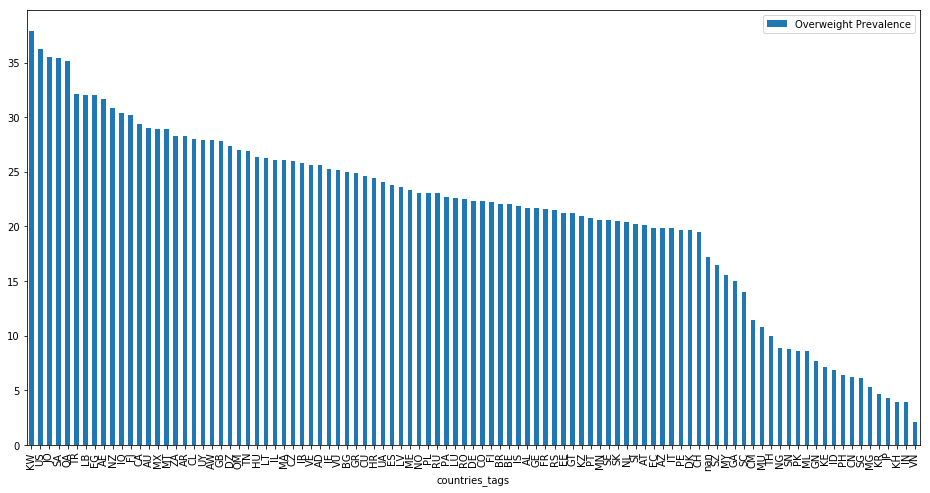

In [145]:
overweight_datas.plot.bar(figsize=(16,8))

### Overweight vs. Fat

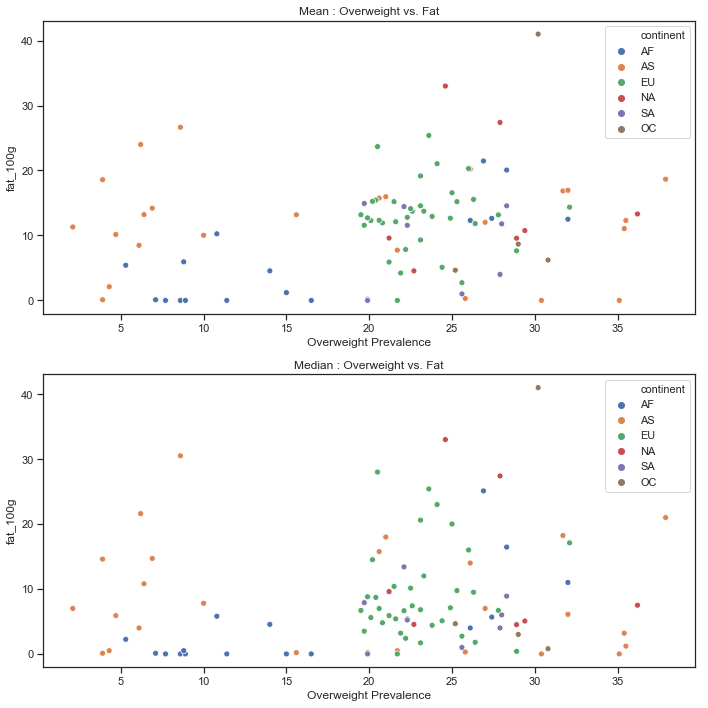

In [168]:
sns_plt(pd.concat(mean_overweight[1:]),pd.concat(median_overweight[1:]), 
        'Overweight Prevalence', 'fat_100g', 'continent', 'Mean', 'Median', 'Overweight vs. Fat')

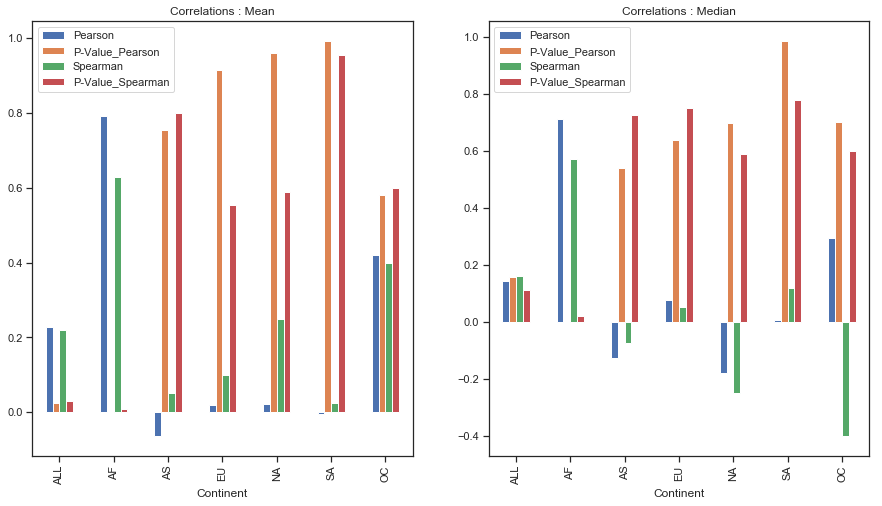

Mean


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.228959,0.023347,0.220379,0.029218
1,AF,0.790805,0.000265,0.629921,0.008916
2,AS,-0.064185,0.755416,0.052326,0.799603
3,EU,0.018124,0.915210,0.100545,0.553780
4,NA,0.023019,0.960933,0.250000,0.588724
5,SA,-0.003835,0.992810,0.023810,0.955374
6,OC,0.419571,0.580429,0.400000,0.600000


Median


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.144080,0.156946,0.161366,0.112430
1,AF,0.711828,0.001981,0.570765,0.020942
2,AS,-0.126092,0.539360,-0.072198,0.725968
3,EU,0.079373,0.640517,0.054192,0.750063
4,NA,-0.179897,0.699514,-0.250000,0.588724
5,SA,0.006895,0.987072,0.119048,0.778886
6,OC,0.296655,0.703345,-0.400000,0.600000


In [159]:
show_corr(mean_overweight, median_overweight, 'Overweight Prevalence', 'fat_100g', 'Mean', 'Median', columns, continent)

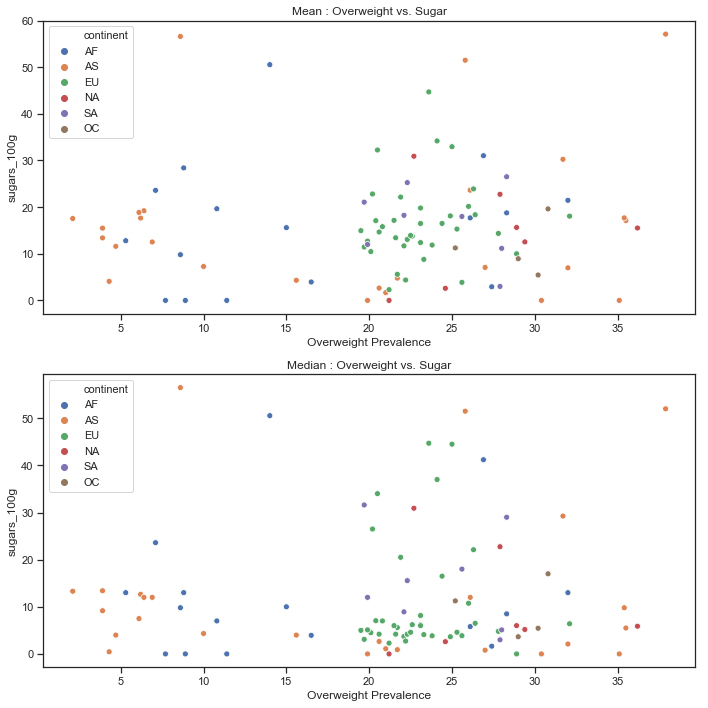

In [169]:
sns_plt(pd.concat(mean_overweight[1:]),pd.concat(median_overweight[1:]), 'Overweight Prevalence', 'sugars_100g', 'continent', 'Mean', 'Median', 'Overweight vs. Sugar')

### Overweight vs. Sugar


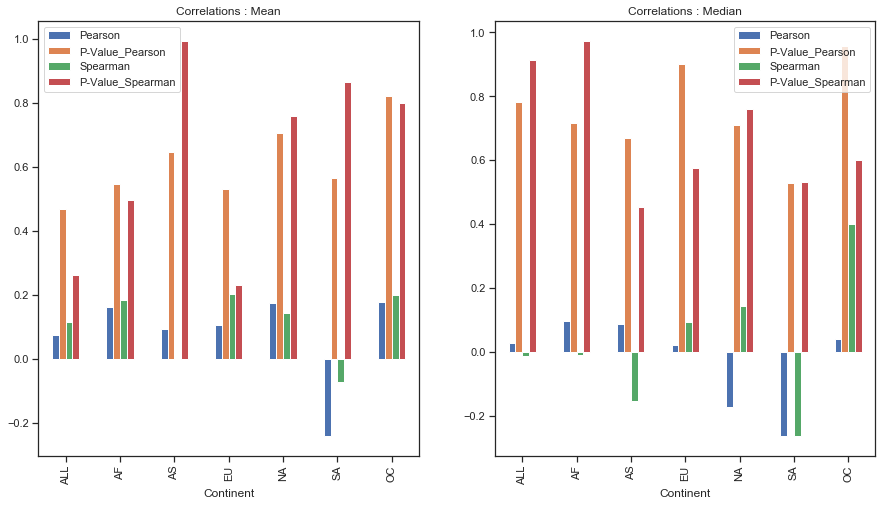

Mean


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.074221,0.467641,0.114176,0.262947
1,AF,0.162509,0.547623,0.182892,0.497786
2,AS,0.094420,0.646378,-0.001369,0.994705
3,EU,0.106353,0.530990,0.202039,0.230454
4,NA,0.174831,0.707713,0.142857,0.759945
5,SA,-0.241663,0.564214,-0.071429,0.866526
6,OC,0.179320,0.820680,0.200000,0.800000


Median


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.028297,0.782097,-0.010894,0.915213
1,AF,0.098019,0.717993,-0.008876,0.973974
2,AS,0.087488,0.670851,-0.153767,0.453268
3,EU,0.021377,0.900061,0.094656,0.577347
4,NA,-0.172829,0.710959,0.142857,0.759945
5,SA,-0.263278,0.528691,-0.261905,0.530923
6,OC,0.040760,0.959240,0.400000,0.600000


In [170]:
show_corr(mean_overweight, median_overweight, 'Overweight Prevalence', 'sugars_100g', 'Mean', 'Median', columns, continent)

Weirdly enough, there is no correlation for the countries with the fattiest/most sugary foods and their overweight prevalence. 
### TODO maybe check sth else. Lin reg

### Diabetes

In [200]:
#drop some useless columns
to_drop=['prev', 'Unnamed: 5']
diab = diabetes.drop(to_drop, axis=1)
#select relevant columns
diab=diab[['country/territory', 'Diabetes [18-99] national prevalence[%]']]
#convert string column to numeric, in order to plot it, remove % at the end
diab['Diabetes [18-99] national prevalence[%]'] = pd.to_numeric(diab['Diabetes [18-99] national prevalence[%]'].str[:-1])
#get country codes
diab['country/territory'] = diab['country/territory'].apply(lambda x: str(x).lower().replace(' ', '-'))
diab = diab.apply(lambda x: get_tag(x, 'country/territory', 'code'), axis=1)
#remove rows without country codes - we have previously checked that most of them are barely represented in our food data
diab = diab[diab['code'] != 'TBD']
#set index for more agreable plotting
diab.set_index('code', inplace=True)
diab = diab[diab.index.isin(indices)]
#sort values
diab= diab.sort_values(by=['Diabetes [18-99] national prevalence[%]'],ascending=False)
diab = diab.rename(columns={'Diabetes [18-99] national prevalence[%]':'Diabetes Prevalence'})
diab.index.name = 'countries_tags'

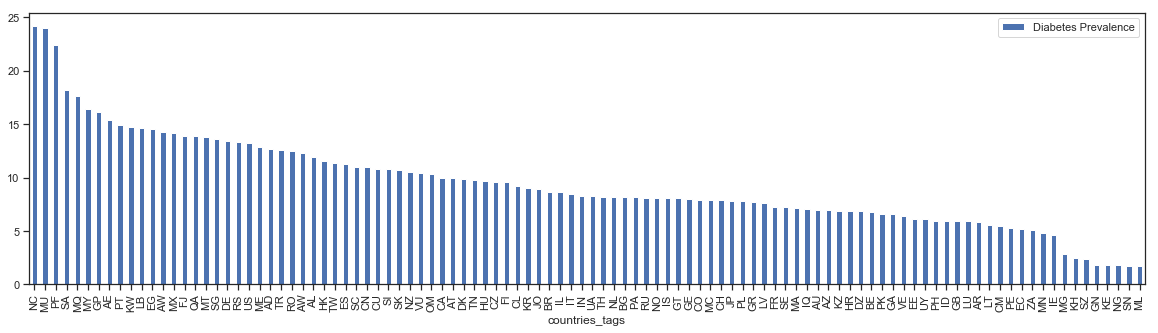

In [201]:
diab.plot.bar(figsize=(20,5))

In [202]:
mean_diabetes = merge_all(means, diab, right_index=True)
median_diabetes = merge_all(medians, diab, right_index=True)

#### Diabetes vs. Fat

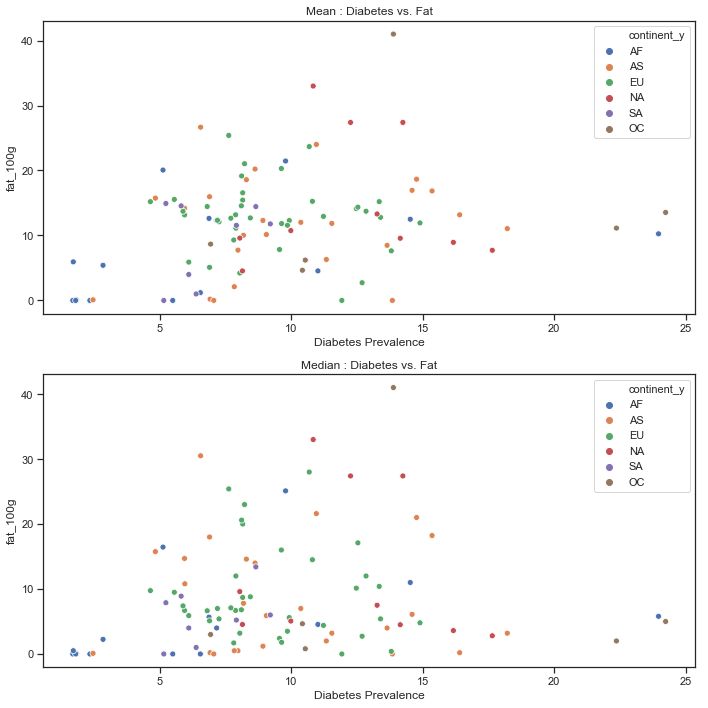

In [206]:
sns_plt(pd.concat(mean_diabetes[1:]),pd.concat(median_diabetes[1:]), 
        'Diabetes Prevalence', 'fat_100g', 'continent_y', 'Mean', 'Median', 'Diabetes vs. Fat')

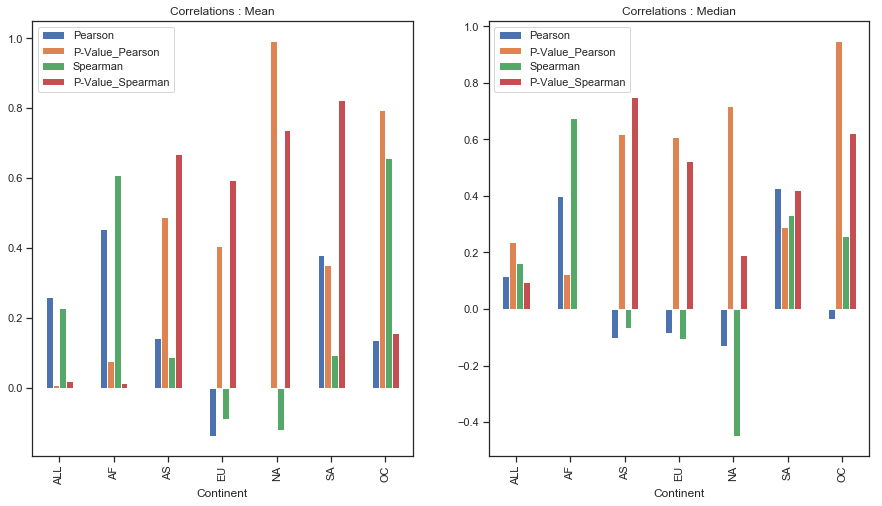

Mean


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.259305,0.007859,0.226950,0.020515
1,AF,0.454888,0.076668,0.607978,0.012470
2,AS,0.141700,0.489883,0.087536,0.670680
3,EU,-0.138526,0.406869,-0.089402,0.593499
4,NA,-0.003066,0.993293,-0.121581,0.737938
5,SA,0.381287,0.351354,0.095238,0.822505
6,OC,0.138002,0.794311,0.657143,0.156175


Median


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.117333,0.235541,0.163793,0.096628
1,AF,0.401445,0.123268,0.676205,0.004028
2,AS,-0.102223,0.619254,-0.065686,0.749874
3,EU,-0.085709,0.608904,-0.106818,0.523274
4,NA,-0.131014,0.718276,-0.449850,0.192076
5,SA,0.427306,0.290986,0.333333,0.419753
6,OC,-0.034090,0.948885,0.257143,0.622787


In [209]:
show_corr(mean_diabetes, median_diabetes, 'Diabetes Prevalence', 'fat_100g', 
          'Mean', 'Median', columns, continent)

#### Diabetes vs. Sugar

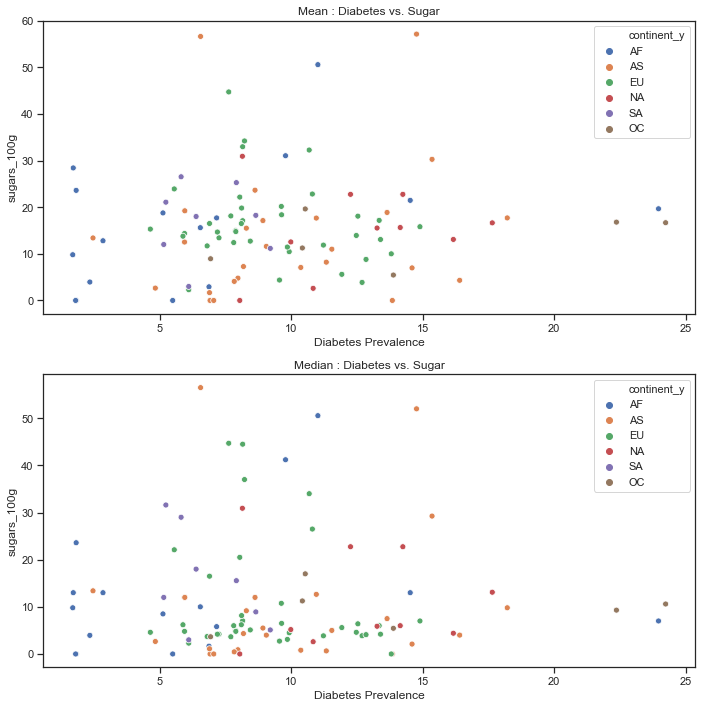

In [208]:
sns_plt(pd.concat(mean_diabetes[1:]),pd.concat(median_diabetes[1:]), 
        'Diabetes Prevalence', 'sugars_100g', 'continent_y', 'Mean', 'Median', 'Diabetes vs. Sugar')

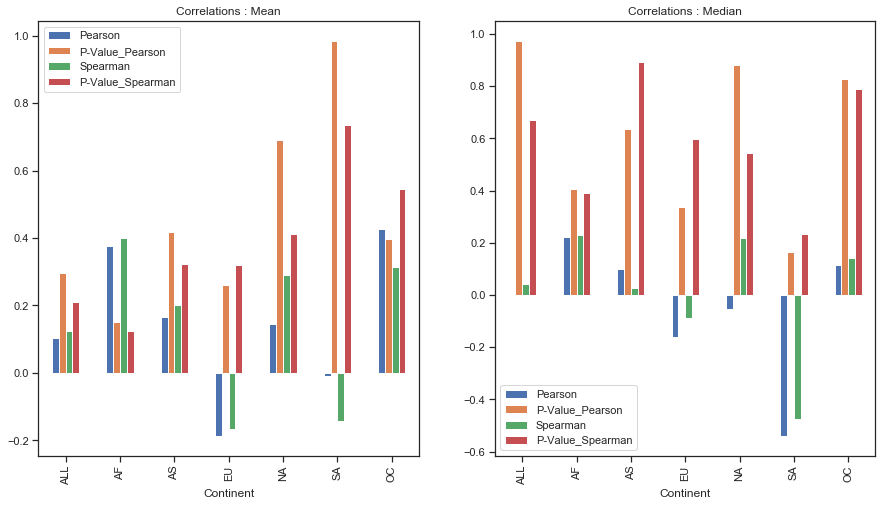

Mean


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,0.103185,0.297250,0.123983,0.209860
1,AF,0.377174,0.149825,0.400001,0.124749
2,AS,0.165528,0.419022,0.201505,0.323583
3,EU,-0.187379,0.259950,-0.165892,0.319550
4,NA,0.144894,0.689615,0.291795,0.413327
5,SA,-0.008166,0.984690,-0.142857,0.735765
6,OC,0.427456,0.397868,0.314286,0.544093


Median


,Continent,Pearson,P-Value_Pearson,Spearman,P-Value_Spearman
0,ALL,-0.003278,0.973654,0.042033,0.671812
1,AF,0.222935,0.406580,0.230943,0.389481
2,AS,0.097587,0.635314,0.027735,0.893014
3,EU,-0.159994,0.337296,-0.088675,0.596519
4,NA,-0.055126,0.879777,0.218846,0.543551
5,SA,-0.540874,0.166290,-0.476190,0.232936
6,OC,0.114561,0.828910,0.142857,0.787172


In [210]:
show_corr(mean_diabetes, median_diabetes, 'Diabetes Prevalence', 'sugars_100g', 
          'Mean', 'Median', columns, continent)

## TODO plot africa mean and south american median

### IHD 

In [291]:
ihd_df = ihd.copy()
ihd['IHD'] = ihd['IHD'].apply(lambda x: x*1000)
ihd['Country'] = ihd['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
ihd = ihd.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
ihd = ihd[ihd['code'] != 'TBD']
ihd = ihd.set_index(['code'])

In [292]:
population['Country'] = population['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
population = population.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
population = population[population['code'] != 'TBD']
population = population.set_index(['code'])

In [258]:
pop_ihd = ihd.merge(population, left_index=True, right_index=True)
pop_ihd.drop(columns=['Country_y'], inplace=True)
pop_ihd['IHD_%'] = ""

In [293]:
def find_percentage(row):
    row['IHD_%'] =  row['IHD'] / row['Population'] * 100
    return row

pop_ihd = pop_ihd.apply(find_percentage, axis=1)
pop_ihd.head()

,Country_x,IHD,alpha3_x,continent_x,Population,alpha3_y,continent_y,IHD_%
code,,,,,,,,
AE,united-arab-emirates,1.200000e+09,ARE,AS,4444011,ARE,AS,27002.633432
AL,albania,5.400000e+09,ALB,EU,3600523,ALB,EU,149978.211499
AR,argentina,3.640000e+10,ARG,SA,40301927,ARG,SA,90318.261953
AT,austria,1.460000e+10,AUT,EU,8199783,AUT,EU,178053.492391
AU,australia,2.490000e+10,AUS,OC,20434176,AUS,OC,121854.681099


### Visualization

In [260]:
def from_2_to_3_country_code(country_tag_2):
    code = countries_infos[countries_infos['COUNTRY_ALPHA2_CODE'] == country_tag_2]['COUNTRY_ALPHA3_CODE'].drop_duplicates()
    if code.size != 1:
        return 'TBD'
    else:
        return code.iloc[0]

In [261]:
def get_code_from_json(json_object):
    found = re.search('.id.\s*:\s*.(\w\w\w).', json_object, re.IGNORECASE)  
    #print(json_object)
    if found:
        json_object = found.group(1)
    return json_object

In [279]:
def get_map(data, values_name, countries='countries_tags'):
    data_for_map = data.reset_index()
    data_for_map[countries] = data_for_map[countries].apply(lambda x: from_2_to_3_country_code(x))
    
    countries_shapes['features'] = countries_shapes['features'].apply(lambda x: get_code_from_json(str(x)))

    for code in countries_shapes['features']:
        if len(code) != 3:
            continue

        if data_for_map[data_for_map[countries] == code].size == 0:
            test = pd.DataFrame(columns=['data_for_map', values_name])
            
            dTest = {
                countries : code,
                values_name : 0
            }
            
            data_for_map = data_for_map.append(dTest, ignore_index=True)
            
        
            
    # Setup a folium map at a high-level zoom
    map = folium.Map(location=[30, 0], zoom_start=2)

    # choropleth maps bind Pandas Data Frames and json geometries.
    #This allows us to quickly visualize data combinations
    map.choropleth(geo_data=DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, data=data_for_map,
                 columns=[countries, values_name],
                 key_on='feature.id',
                 fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
                 legend_name=values_name)
    return map

In [280]:
sugar_map = get_map(mean['sugars_100g'], 'sugars_100g')
sugar_map

In [281]:
fat_map = get_map(mean['fat_100g'], 'fat_100g')
fat_map

In [282]:
ow_data = get_map(overweight_datas, 'Overweight Prevalence')
ow_data

In [283]:
prot_map = get_map(mean[['proteins_100g']], 'proteins_100g')
prot_map

In [284]:
diab_map = get_map(diab[['Diabetes Prevalence']], 'Diabetes Prevalence')
diab_map

In [286]:
pop_ihd

,Country_x,IHD,alpha3_x,continent_x,Population,alpha3_y,continent_y,IHD_%
code,,,,,,,,
AE,united-arab-emirates,1.200000e+09,ARE,AS,4444011,ARE,AS,27002.633432
AL,albania,5.400000e+09,ALB,EU,3600523,ALB,EU,149978.211499
AR,argentina,3.640000e+10,ARG,SA,40301927,ARG,SA,90318.261953
AT,austria,1.460000e+10,AUT,EU,8199783,AUT,EU,178053.492391
AU,australia,2.490000e+10,AUS,OC,20434176,AUS,OC,121854.681099
AZ,azerbaijan,1.630000e+10,AZE,AS,8120247,AZE,AS,200732.810221
BD,bangladesh,1.634000e+11,BGD,AS,150448339,BGD,AS,108608.709864
BE,belgium,1.390000e+10,BEL,EU,10392226,BEL,EU,133753.827140
BG,bulgaria,2.310000e+10,BGR,EU,7322858,BGR,EU,315450.606853


In [290]:
ihd_map = get_map(pop_ihd[['IHD_%']], 'IHD_%', countries='code')
ihd_map